# Climate data analysis with **Dask**

#### Comparing historical and future temperature over Europe

<img src="./imgs/Dask.png" width="300"/>

This notebook provides an example of climate data analysis performed in parallel with [Dask](https://dask.org/). In particular, it shows how to:

  - exploit the **search & discover** features to investigate the content of the data catalog associated with the ENES Data Space archive
  - use **Dask** and **xarray** to analyze data in **parallel**
  - use the **data visualization libraries** (e.g. *matplotlib* and *Cartopy*) to plot the analysis results

In [2]:
import os
import dask
import intake
import xarray as xr
from os.path import expanduser
import ipywidgets as widgets
home = expanduser("~")
from dask.distributed import Client, LocalCluster
worker_kwargs = {'local_directory': '/home/jovyan'}

### Search & Discover data with **intake-esm**

Open the ESM collection file

In [11]:
esm_file = home+"/data/CMIP6_ESM_colletion_file.json"
col = intake.open_esm_datastore(esm_file)
col.df.head()

,Unnamed: 0,index,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,version,time_range,start_year,end_year,path
0,0,0,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,huss,gn,v20200623,185001-201412,185001.0,201412.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...
1,1,1,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,pr,gn,v20200623,185001-201412,185001.0,201412.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...
2,2,2,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,tas,gn,v20200623,185001-201412,185001.0,201412.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...
3,3,3,CMIP,AS-RCEC,TaiESM1,historical,r2i1p1f1,Amon,huss,gn,v20210416,185001-201412,185001.0,201412.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...
4,4,4,CMIP,AS-RCEC,TaiESM1,historical,r2i1p1f1,Amon,pr,gn,v20210416,185001-201412,185001.0,201412.0,/home/jovyan/data/CMIP6/CMIP/AS-RCEC/TaiESM1/h...


Discover the catalog entries

a) Get the column labels

In [3]:
col.df.columns

Index(['Unnamed: 0', 'index', 'activity_id', 'institution_id', 'source_id',
       'experiment_id', 'member_id', 'table_id', 'variable_id', 'grid_label',
       'version', 'time_range', 'start_year', 'end_year', 'path'],
      dtype='object')

b) Get the list of the available experiments

In [4]:
experiments = col.unique(columns=["experiment_id"])
experiments

{'experiment_id': {'count': 10,
  'values': ['ssp585',
   'highres-future',
   'hist-1950',
   'spinup-1950',
   'ssp370',
   'highresSST-present',
   'ssp245',
   'highresSST-future',
   'historical',
   'control-1950']}}

f) Get the available variables for a specific experiment

In [5]:
col.df.loc[col.df['experiment_id'] == "ssp245"]["variable_id"].unique()

array(['huss', 'pr', 'tas', 'hurs', 'uas', 'vas', 'tasmax', 'tasmin'],
      dtype=object)

### Compute the mean temperature over the EU spatial domain for a CMIP Historical Simulation (1850–near-present)

Deploy a Dask Local cluster

In [6]:
cluster = LocalCluster(n_workers=5, threads_per_worker=3, **worker_kwargs)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 15,Total memory: 15.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37663,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 15
Started: Just now,Total memory: 15.00 GiB
Comm: tcp://127.0.0.1:34195,Total threads: 3
Dashboard: http://127.0.0.1:33649/status,Memory: 3.00 GiB
Nanny: tcp://127.0.0.1:34067,


Define the EU bounding box

In [7]:
# EUROPE
north= 70.94985882321207
south= 35.049860308608224
east= 40
west= -24.950139509199722

Search & Load data

We are interested in:
  - `historical` experiment from `EC-Earth3` model
  - `tas` variable at `daily` frequency
  - `r1i1p1f1` ensemble member

In [8]:
query = dict( 
    experiment_id="historical",
    source_id="EC-Earth3",
    variable_id="tas",
    table_id="day",
    member_id="r1i1p1f1"
)
cat = col.search(**query)
paths = cat.df['path'].values

,Unnamed: 0,index,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,version,time_range,start_year,end_year,path
0,175539,21556,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tas,gr,v20200310,18500101-18501231,1850.0,1850.0,/home/jovyan/data/CMIP6/CMIP/EC-Earth-Consorti...
1,175540,21557,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tas,gr,v20200310,18510101-18511231,1851.0,1851.0,/home/jovyan/data/CMIP6/CMIP/EC-Earth-Consorti...
2,175541,21558,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tas,gr,v20200310,18520101-18521231,1852.0,1852.0,/home/jovyan/data/CMIP6/CMIP/EC-Earth-Consorti...
3,175542,21559,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tas,gr,v20200310,18530101-18531231,1853.0,1853.0,/home/jovyan/data/CMIP6/CMIP/EC-Earth-Consorti...
4,175543,21560,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tas,gr,v20200310,18540101-18541231,1854.0,1854.0,/home/jovyan/data/CMIP6/CMIP/EC-Earth-Consorti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,175699,21716,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tas,gr,v20200310,20100101-20101231,2010.0,2010.0,/home/jovyan/data/CMIP6/CMIP/EC-Earth-Consorti...
161,175700,21717,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tas,gr,v20200310,20110101-20111231,2011.0,2011.0,/home/jovyan/data/CMIP6/CMIP/EC-Earth-Consorti...
162,175701,21718,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tas,gr,v20200310,20120101-20121231,2012.0,2012.0,/home/jovyan/data/CMIP6/CMIP/EC-Earth-Consorti...
163,175702,21719,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tas,gr,v20200310,20130101-20131231,2013.0,2013.0,/home/jovyan/data/CMIP6/CMIP/EC-Earth-Consorti...


Inspect the data structure

In [9]:
ds = xr.open_mfdataset(paths, combine='nested', concat_dim="time", parallel=True, engine='h5netcdf')
ds["tas"]

<xarray.DataArray 'tas' (time: 60265, lat: 256, lon: 512)>
dask.array<concatenate, shape=(60265, 256, 512), dtype=float32, chunksize=(366, 256, 512), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
    height   float64 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-09-25T21:09:13Z altered by CMOR: Treated scalar dime...

Compute the temporal mean

In [10]:
mean = ds['tas'].sel(lat=slice(south,north), lon=slice(west,east)).mean(dim='time') 
result = mean.compute()

Inspect the structure of the output data

In [11]:
mean

<xarray.DataArray 'tas' (lat: 51, lon: 57)>
dask.array<mean_agg-aggregate, shape=(51, 57), dtype=float32, chunksize=(51, 57), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 35.44 36.14 36.84 37.54 ... 68.42 69.12 69.82 70.53
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 37.27 37.97 38.67 39.38
    height   float64 2.0

Export the result to a NetCDF file

In [12]:
result.to_netcdf(home+'/work/mean_tas_1850-1914.nc')

Plot the result on a map

In [13]:
def plot(result):
    %matplotlib inline
    import cartopy
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.util import add_cyclic_point
    import numpy as np
    import warnings
    warnings.filterwarnings("ignore")

    fig = plt.figure(figsize=(15, 6), dpi=100)

    #Add Geo axes to the figure with the specified projection (PlateCarree)
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)

    #Draw coastline and gridlines
    ax.coastlines()

    gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False

    result_celsius = result - 273
    lat = result_celsius.lat.values
    lon = result_celsius.lon.values
    var = result_celsius.values
    var = np.reshape(var, (len(lat), len(lon)))

    #Wraparound points in longitude
    var_cyclic, lon_cyclic = add_cyclic_point(var, coord=np.asarray(lon))
    x, y = np.meshgrid(lon_cyclic,lat)

    #Define color levels for color bar
    #levStep = (np.nanmax(var)-np.nanmin(var))/20
    #clevs = np.arange(np.nanmin(var),np.nanmax(var)+levStep,levStep)
    levStep = (25.0-(-10.0))/20
    clevs = np.arange(-10.0,25.0+levStep,levStep)
    
    
    #Set filled contour plot
    cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.jet)
    plt.colorbar(cnplot,ax=ax)

    #ax.set_aspect('auto', adjustable=None)
    plt.title('Mean Air Temperature (deg C) over 1850-1914')
    plt.savefig('Mean_Temperature_1850-2914.png')
    plt.show()

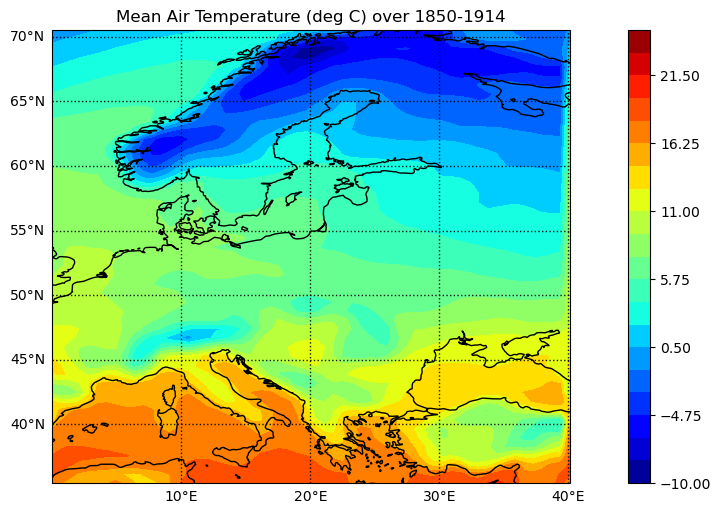

In [14]:
plot(result)

### Compute the mean temperature on yearly basis over the EU spatial domain for a CMIP future climate scenario (2015–end of 21st century)

e.g. `SSP2-4.5`: a “Middle of the Road” scenario (Medium challenges to mitigation and adaptation)
  - CO2 emissions hover around current levels before starting to fall mid-century, but do not reach net-zero by 2100. 
  - Socioeconomic factors follow their historic trends, with no notable shifts. 
  - Progress toward sustainability is slow, with development and income growing unevenly. 

Search & Load data

We select the desired future scenario experiment (`ssp245`) from the same model (`EC-Earth3`)

In [15]:
query = dict( 
    experiment_id="ssp245",
    source_id="EC-Earth3",
    variable_id="tas",
    table_id="day",
    member_id="r1i1p1f1"
)
cat = col.search(**query)
paths = cat.df['path'].values
paths

array(['/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r1i1p1f1/day/tas/gr/v20200310/tas_day_EC-Earth3_ssp245_r1i1p1f1_gr_20150101-20151231.nc',
       '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r1i1p1f1/day/tas/gr/v20200310/tas_day_EC-Earth3_ssp245_r1i1p1f1_gr_20160101-20161231.nc',
       '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r1i1p1f1/day/tas/gr/v20200310/tas_day_EC-Earth3_ssp245_r1i1p1f1_gr_20170101-20171231.nc',
       '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r1i1p1f1/day/tas/gr/v20200310/tas_day_EC-Earth3_ssp245_r1i1p1f1_gr_20180101-20181231.nc',
       '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r1i1p1f1/day/tas/gr/v20200310/tas_day_EC-Earth3_ssp245_r1i1p1f1_gr_20190101-20191231.nc',
       '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r1i1p1f1/day/tas/gr/v20200310/tas_day_EC-Earth3_ssp245_r1i1p1f1_

Inspect the data structure

In [16]:
ds = xr.open_mfdataset(paths, combine='nested', concat_dim="time", parallel=True, engine='h5netcdf')
ds["tas"]

<xarray.DataArray 'tas' (time: 31411, lat: 256, lon: 512)>
dask.array<concatenate, shape=(31411, 256, 512), dtype=float32, chunksize=(366, 256, 512), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
    height   float64 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-09-26T21:43:06Z altered by CMOR: Treated scalar dime...

Compute the temporal mean on yearly basis

In [17]:
yearly_mean = ds['tas'].sel(lat=slice(south,north), lon=slice(west,east)).groupby('time.year').mean(dim='time')
result = yearly_mean.compute()

Convert temperature from Kelvin to Celsius degrees

In [18]:
result_celsius = result - 273

Inspect the structure of the output data

In [19]:
yearly_mean

<xarray.DataArray 'tas' (year: 86, lat: 51, lon: 57)>
dask.array<stack, shape=(86, 51, 57), dtype=float32, chunksize=(1, 51, 57), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 35.44 36.14 36.84 37.54 ... 68.42 69.12 69.82 70.53
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 37.27 37.97 38.67 39.38
    height   float64 2.0
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

Create an animated image showing the yearly mean temperature in Europe until 2100

In [21]:
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import imageio
import ipywidgets as widgets

images = []
img='/home/jovyan/work/yearly_mean_'

start_year=np.min(result.year.values)
end_year=np.max(result.year.values)
#levStep = (np.nanmax(result_celsius.values)-np.nanmin(result_celsius.values))/20
#clevs = np.arange(np.nanmin(result_celsius.values),np.nanmax(result_celsius.values)+levStep,levStep)
levStep = (25.0-(-10.0))/20
clevs = np.arange(-10.0,25.0+levStep,levStep)
    
for i in result_celsius.year.values:

    lat = result_celsius.sel(year=i).lat.values
    lon = result_celsius.sel(year=i).lon.values
    var = result_celsius.sel(year=i).values
    var = np.reshape(var, (len(lat), len(lon)))
    
    fig = plt.figure(figsize=(15, 6), dpi=100)

    #Add Geo axes to the figure with the specified projection (PlateCarree)
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)

    #Draw coastline and gridlines
    ax.coastlines()

    gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False

    #Wraparound points in longitude
    var_cyclic, lon_cyclic = add_cyclic_point(var, coord=np.asarray(lon))
    x, y = np.meshgrid(lon_cyclic,lat)

    #Set filled contour plot
    #cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.coolwarm)
    cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.jet)
    plt.colorbar(cnplot,ax=ax)

    #ax.set_aspect('auto', adjustable=None)
    
    plt.title('Mean temperature (year '+str(i)+')')
    plt.savefig(img+str(i)+'.png', dpi=fig.dpi, bbox_inches='tight')
    plt.close()

    images.append(imageio.imread(img+str(i)+'.png')) 
    try:
        os.remove(img+str(i)+'.png')
    except:
        pass
             
args = { 'duration': 0.5 }
imageio.mimsave('/home/jovyan/work/Mean_Temperature_{}-{}.gif'.format(start_year,end_year), images, 'gif', **args)

In [22]:
with open("/home/jovyan/work/Mean_Temperature_{}-{}.gif".format(start_year,end_year), "rb") as file:
    image = file.read()

widgets.Image(
    value=image,
    format='gif'
)

Image(value=b'GIF89a\xd1\x02\x02\x02\x87\x00\x00\xff\xff\xff\xe4\xff\x13\xba\xff<\x90\xffff\xff\x90<\xff\xba\x…